In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.amp import GradScaler, autocast

from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import os
import requests
import zipfile
import re
import gc

In [12]:

# --- GloVe Configuration ---
GLOVE_FILE_NAME = 'glove.6B.300d.txt'
GLOVE_EMBEDDING_DIM = 300
GLOVE_PATH = f'./{GLOVE_FILE_NAME}'
GLOVE_ZIP_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_LOCAL_ZIP_PATH = './glove.6B.zip'

# --- Model & Training Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# **** MEMORY OPTIMIZATION: Reduced BATCH_SIZE ****
ACCUMULATION_STEPS = 4 # Effective batch size will be BATCH_SIZE * ACCUMULATION_STEPS (8*4=32)
BATCH_SIZE = 8 # Reduced from 32. Try 8 if still OOM.

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 20
VALID_SET_SIZE = 0.2
MIN_CLASS_REPRESENTATION = 2 # For stratified split

# --- RNN Specific Hyperparameters ---
RNN_TYPE_CLASS = nn.LSTM
# **** MEMORY OPTIMIZATION: Consider reducing RNN_HIDDEN_SIZE if OOM persists ****
RNN_HIDDEN_SIZE = 128   # Try 64 for further memory saving
RNN_NUM_LAYERS = 1
# **** MEMORY OPTIMIZATION: Consider RNN_BIDIRECTIONAL = False if OOM persists ****
RNN_BIDIRECTIONAL = True
RNN_DROPOUT_RATE = 0.4 # Dropout for RNN and before final FC

# Max Sequence Length for Truncation
MAX_SEQ_LEN = 256



In [3]:
def ensure_glove_file_is_present():
    if os.path.exists(GLOVE_PATH):
        print(f"Found existing GloVe text file: {GLOVE_PATH}")
        return True
    if not os.path.exists(GLOVE_LOCAL_ZIP_PATH):
        print(f"GloVe zip file {GLOVE_LOCAL_ZIP_PATH} not found. Attempting to download from {GLOVE_ZIP_URL}...")
        try:
            response = requests.get(GLOVE_ZIP_URL, stream=True)
            response.raise_for_status()
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            block_size = 1024
            with open(GLOVE_LOCAL_ZIP_PATH, 'wb') as file, tqdm(
                desc=f"Downloading {os.path.basename(GLOVE_ZIP_URL)}",
                total=total_size_in_bytes, unit='iB', unit_scale=True, unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(block_size):
                    bar.update(len(data))
                    file.write(data)
            print(f"Successfully downloaded {GLOVE_LOCAL_ZIP_PATH}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading GloVe zip file: {e}")
            if os.path.exists(GLOVE_LOCAL_ZIP_PATH): os.remove(GLOVE_LOCAL_ZIP_PATH)
            return False
        except Exception as e:
            print(f"An unexpected error occurred during download: {e}")
            if os.path.exists(GLOVE_LOCAL_ZIP_PATH): os.remove(GLOVE_LOCAL_ZIP_PATH)
            return False
    else:
        print(f"Found existing GloVe zip file: {GLOVE_LOCAL_ZIP_PATH}")

    print(f"Attempting to extract {GLOVE_FILE_NAME} from {GLOVE_LOCAL_ZIP_PATH}...")
    try:
        with zipfile.ZipFile(GLOVE_LOCAL_ZIP_PATH, 'r') as zip_ref:
            if GLOVE_FILE_NAME in zip_ref.namelist():
                zip_ref.extract(GLOVE_FILE_NAME, path=os.path.dirname(GLOVE_PATH) or '.')
                print(f"Successfully extracted {GLOVE_FILE_NAME} to {GLOVE_PATH}")
                return True
            else:
                print(f"Error: {GLOVE_FILE_NAME} not found inside {GLOVE_LOCAL_ZIP_PATH}.")
                print(f"Available files: {zip_ref.namelist()}")
                return False
    except zipfile.BadZipFile:
        print(f"Error: {GLOVE_LOCAL_ZIP_PATH} is a bad zip file. Please delete it and try again.")
        return False
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
        return False

if not ensure_glove_file_is_present():
    print("Could not obtain GloVe file. Exiting.")
    exit()

def load_glove_vectors(glove_path, embedding_dim):
    print(f"Loading GloVe vectors from {glove_path} with dimension {embedding_dim}...")
    if not os.path.exists(glove_path):
        print(f"Error: GloVe file not found at {glove_path}.")
        return None
    word_to_vec = {}
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading GloVe"): 
                values = line.split()
                word = values[0]
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    if len(vector) == embedding_dim:
                        word_to_vec[word] = vector
                except ValueError:
                    pass # Skip malformed lines
    except Exception as e:
        print(f"An error occurred while reading the GloVe file: {e}")
        return None
    if not word_to_vec:
        print(f"No word vectors loaded from {glove_path}.")
        return None
    print(f"Successfully loaded {len(word_to_vec)} word vectors.")
    return word_to_vec


glove_vectors_map_global = load_glove_vectors(GLOVE_PATH, GLOVE_EMBEDDING_DIM)
unk_embedding_global = np.random.rand(GLOVE_EMBEDDING_DIM).astype('float32')
if glove_vectors_map_global:
    if '[unk]' in glove_vectors_map_global: unk_embedding_global = glove_vectors_map_global['[unk]']
    elif 'unk' in glove_vectors_map_global: unk_embedding_global = glove_vectors_map_global['unk']
else:
    print("GloVe vectors map is empty or not loaded. Using random UNK embedding. Training will be affected.")


Found existing GloVe text file: ./glove.6B.300d.txt
Loading GloVe vectors from ./glove.6B.300d.txt with dimension 300...


Loading GloVe: 400000it [00:13, 29437.33it/s]

Successfully loaded 400000 word vectors.


In [4]:
print("Loading BERT tokenizer...")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
print("Tokenizer loaded.")



Loading BERT tokenizer...
Tokenizer loaded.


In [5]:
print("Loading gcc_data.csv...")
try:
    df = pd.read_csv('../datasets/gcc_data.csv')
except FileNotFoundError:
    print("Error: gcc_data.csv not found. Please place it in the script's directory or provide the full path.")
    exit()

print(f"Original gcc_data shape: {df.shape}")
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Description'] = df['Description'].fillna('').astype(str)
df['text_input'] = df['Summary'] + " " + df['Description']
df.dropna(subset=['Assignee'], inplace=True)
df['Assignee'] = df['Assignee'].astype(str)
print(f"Shape after dropping NA assignees: {df.shape}")

assignee_encoder = LabelEncoder()
df['assignee_encoded'] = assignee_encoder.fit_transform(df['Assignee'])
NUM_ACTUAL_CLS = len(assignee_encoder.classes_)
print(f"Number of unique assignees (classes): {NUM_ACTUAL_CLS}")
if NUM_ACTUAL_CLS <= 1:
    print("Error: Only one or no classes found after encoding. Cannot train classifier.")
    exit()


Loading gcc_data.csv...
Original gcc_data shape: (2103, 5)
Shape after dropping NA assignees: (2103, 6)
Number of unique assignees (classes): 82


In [6]:
texts = df['text_input'].tolist()
labels = df['assignee_encoded'].tolist()
assignee_counts = df['Assignee'].value_counts()
small_classes = assignee_counts[assignee_counts < MIN_CLASS_REPRESENTATION].index.tolist()
stratify_labels = labels if not small_classes and NUM_ACTUAL_CLS > 0 else None

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=VALID_SET_SIZE, random_state=42, shuffle=True, stratify=stratify_labels
)
print(f"Train set size: {len(train_texts)}, Test set size: {len(test_texts)}")

def create_data_list(texts_list, labels_list): # Renamed parameters for clarity
    return [{'text': text, 'label': label} for text, label in zip(texts_list, labels_list)]

train_data_list = create_data_list(train_texts, train_labels)
test_data_list = create_data_list(test_texts, test_labels)



Train set size: 1682, Test set size: 421


In [7]:
def collate_with_glove(batch, hf_tokenizer, glove_word_vectors, embedding_dimension, unk_word_embedding, max_seq_len):
    labels_list_from_batch = [item['label'] for item in batch]
    texts_list_from_batch = [item['text'] for item in batch]
    labels_tensor = torch.LongTensor(labels_list_from_batch)
    all_sequences_as_vecs = []
    for text_item in texts_list_from_batch:
        string_tokens = hf_tokenizer.tokenize(str(text_item))[:max_seq_len] 
        if not string_tokens:
            all_sequences_as_vecs.append(torch.tensor(unk_word_embedding, dtype=torch.float).unsqueeze(0))
            continue
        current_sequence_embeddings = [torch.tensor(glove_word_vectors.get(token_str, unk_word_embedding), dtype=torch.float) for token_str in string_tokens]
        if not current_sequence_embeddings:
            all_sequences_as_vecs.append(torch.tensor(unk_word_embedding, dtype=torch.float).unsqueeze(0))
        else:
            all_sequences_as_vecs.append(torch.stack(current_sequence_embeddings))
    vecs_padded = pad_sequence(all_sequences_as_vecs, batch_first=False, padding_value=0.0)
    return vecs_padded, labels_tensor

train_loader_global, test_loader_global = None, None
if glove_vectors_map_global is not None and train_data_list and test_data_list:
    collate_fn_custom = partial(collate_with_glove,
                                 hf_tokenizer=tokenizer,
                                 glove_word_vectors=glove_vectors_map_global,
                                 embedding_dimension=GLOVE_EMBEDDING_DIM,
                                 unk_word_embedding=unk_embedding_global,
                                 max_seq_len=MAX_SEQ_LEN)
    train_loader_global = DataLoader(train_data_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_custom, pin_memory=True if DEVICE=='cuda' else False, num_workers=0)
    test_loader_global = DataLoader(test_data_list, batch_size=BATCH_SIZE, collate_fn=collate_fn_custom, pin_memory=True if DEVICE=='cuda' else False, num_workers=0)
    print("DataLoaders created for gcc_data.")
else:
    print("GloVe vectors not loaded or data lists are empty. Cannot create DataLoaders.")


DataLoaders created for gcc_data.


In [8]:
class AverageMeter(object):
    def __init__(self): self.reset()
    def reset(self): self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val; self.sum += val * n; self.count += n; self.avg = self.sum / self.count

class RNNModel(nn.Module):
  def __init__(self, RNN_cell_type, input_size, hidden_size, num_layers, bidirectional, num_cls, dropout_rate=0.5):
    super().__init__()
    self.rnn = RNN_cell_type(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             bidirectional=bidirectional,
                             batch_first=False,
                             dropout=dropout_rate if num_layers > 1 else 0) 
    fc_input_features = hidden_size * 2 if bidirectional else hidden_size
    self.fc = nn.Linear(fc_input_features, num_cls) 
    self.dropout_fc = nn.Dropout(dropout_rate)

  def forward(self, x):
    outputs, _ = self.rnn(x) # outputs: (seq_len, batch, num_directions * hidden_size)
    # Aggregate RNN outputs. Using mean pooling over time steps.
    out = outputs.mean(dim=0) # Shape: (batch, num_directions * hidden_size)
    out = self.dropout_fc(out)
    y = self.fc(out) # Shape: (batch, num_cls)
    return y


In [15]:
scaler = GradScaler('cuda')

def train_one_epoch(model, dataloader, loss_function, optim, current_epoch=None, accumulation_steps=1):
    model.train()
    loss_meter = AverageMeter()
    correct_predictions = 0
    total_samples = 0
    
    optim.zero_grad() # Zero gradients at the beginning of accumulation cycle or epoch

    tepoch = tqdm(dataloader, unit="batch")
    if current_epoch is not None: tepoch.set_description(f"Epoch {current_epoch+1}")
    
    for i, (inputs, targets) in enumerate(tepoch):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        with autocast('cuda'):
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            if accumulation_steps > 1:
                loss = loss / accumulation_steps 
        
        scaler.scale(loss).backward() 
        
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.step(optim) 
            scaler.update()    
            optim.zero_grad() 
        
        # Log un-normalized loss for comparability if accumulating
        log_loss = loss.item() * accumulation_steps if accumulation_steps > 1 else loss.item()
        # Correct batch size for loss meter update, inputs.size(1) is batch_size for batch_first=False
        current_batch_size = inputs.size(1) if inputs.dim() > 1 else 1 
        loss_meter.update(log_loss, current_batch_size)
        
        _, predicted_labels = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted_labels == targets).sum().item()
        tepoch.set_postfix(loss=loss_meter.avg, accuracy=100. * correct_predictions / total_samples if total_samples > 0 else 0.0)
    
    epoch_accuracy = 100. * correct_predictions / total_samples if total_samples > 0 else 0.0
    return model, loss_meter.avg, epoch_accuracy

def validate_model(model, dataloader, loss_function):
    model.eval()
    loss_meter = AverageMeter()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad(), tqdm(dataloader, unit="batch", desc="Validating") as tepoch:
        for inputs, targets in tepoch:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            with autocast('cuda'):
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
            current_batch_size = inputs.size(1) if inputs.dim() > 1 else 1
            loss_meter.update(loss.item(), current_batch_size)
            _, predicted_labels = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted_labels == targets).sum().item()
            tepoch.set_postfix(loss=loss_meter.avg, accuracy=100. * correct_predictions / total_samples if total_samples > 0 else 0.0)
    epoch_accuracy = 100. * correct_predictions / total_samples if total_samples > 0 else 0.0
    return loss_meter.avg, epoch_accuracy



Using device: cuda
CUDA Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Initial GPU Memory: Free 3768.00MB / Total 3897.75MB

Sample batch - X shape: torch.Size([256, 8, 300]), Y shape: torch.Size([8])

RNN Model (LSTM) Initialized with 82 output classes.
  Hidden Size: 128, Bidirectional: True, Layers: 1

--- Starting Model Training (RNN with AMP, Grad Accum 4 steps, Batch Size 8) ---


Validating: 100%|██████████| 53/53 [00:01<00:00, 51.24batch/s, accuracy=12.8, loss=3.45]


Epoch 1/20 - Train Loss: 3.6502, Train Acc: 12.84%
Validation: Loss = 3.4454, Accuracy = 12.83%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 47.68batch/s, accuracy=13.5, loss=3.36]


Epoch 2/20 - Train Loss: 3.3769, Train Acc: 15.10%
Validation: Loss = 3.3587, Accuracy = 13.54%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 51.62batch/s, accuracy=15, loss=3.37]  


Epoch 3/20 - Train Loss: 3.2607, Train Acc: 17.54%
Validation: Loss = 3.3691, Accuracy = 14.96%
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 49.54batch/s, accuracy=21.4, loss=3.26]


Epoch 4/20 - Train Loss: 3.1846, Train Acc: 20.27%
Validation: Loss = 3.2569, Accuracy = 21.38%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 49.79batch/s, accuracy=23.3, loss=3.23]


Epoch 5/20 - Train Loss: 3.0954, Train Acc: 23.84%
Validation: Loss = 3.2300, Accuracy = 23.28%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:00<00:00, 54.77batch/s, accuracy=24.5, loss=3.12]


Epoch 6/20 - Train Loss: 3.0157, Train Acc: 24.97%
Validation: Loss = 3.1157, Accuracy = 24.47%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 48.64batch/s, accuracy=28.5, loss=3.03]


Epoch 7/20 - Train Loss: 2.9782, Train Acc: 27.47%
Validation: Loss = 3.0307, Accuracy = 28.50%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 50.80batch/s, accuracy=32.5, loss=2.95]


Epoch 8/20 - Train Loss: 2.8275, Train Acc: 31.39%
Validation: Loss = 2.9550, Accuracy = 32.54%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:00<00:00, 53.80batch/s, accuracy=31.8, loss=2.92]


Epoch 9/20 - Train Loss: 2.8185, Train Acc: 31.39%
Validation: Loss = 2.9226, Accuracy = 31.83%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 49.59batch/s, accuracy=30.6, loss=2.81]


Epoch 10/20 - Train Loss: 2.6531, Train Acc: 34.24%
Validation: Loss = 2.8132, Accuracy = 30.64%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 47.57batch/s, accuracy=31.4, loss=2.76]


Epoch 11/20 - Train Loss: 2.5506, Train Acc: 35.79%
Validation: Loss = 2.7643, Accuracy = 31.35%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 48.77batch/s, accuracy=33.3, loss=2.76]


Epoch 12/20 - Train Loss: 2.5045, Train Acc: 36.74%
Validation: Loss = 2.7636, Accuracy = 33.25%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 44.26batch/s, accuracy=34.2, loss=2.68]


Epoch 13/20 - Train Loss: 2.4295, Train Acc: 38.11%
Validation: Loss = 2.6833, Accuracy = 34.20%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 46.14batch/s, accuracy=36.6, loss=2.65]


Epoch 14/20 - Train Loss: 2.3438, Train Acc: 40.43%
Validation: Loss = 2.6514, Accuracy = 36.58%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 45.12batch/s, accuracy=37.8, loss=2.63]


Epoch 15/20 - Train Loss: 2.2770, Train Acc: 40.90%
Validation: Loss = 2.6287, Accuracy = 37.77%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 41.72batch/s, accuracy=36.3, loss=2.62]


Epoch 16/20 - Train Loss: 2.1812, Train Acc: 43.22%
Validation: Loss = 2.6197, Accuracy = 36.34%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 46.84batch/s, accuracy=35.9, loss=2.63]


Epoch 17/20 - Train Loss: 2.1636, Train Acc: 43.40%
Validation: Loss = 2.6261, Accuracy = 35.87%
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 46.31batch/s, accuracy=38, loss=2.61]  


Epoch 18/20 - Train Loss: 2.1460, Train Acc: 44.89%
Validation: Loss = 2.6148, Accuracy = 38.00%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 46.30batch/s, accuracy=36.8, loss=2.61]


Epoch 19/20 - Train Loss: 2.0434, Train Acc: 45.90%
Validation: Loss = 2.6063, Accuracy = 36.82%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------


Validating: 100%|██████████| 53/53 [00:01<00:00, 50.54batch/s, accuracy=39, loss=2.52]  


Epoch 20/20 - Train Loss: 1.9965, Train Acc: 46.25%
Validation: Loss = 2.5185, Accuracy = 38.95%
Model Saved as rnn_model_bug_assign_best.pt!
------------------------------
--- Training Finished (RNN with AMP) ---


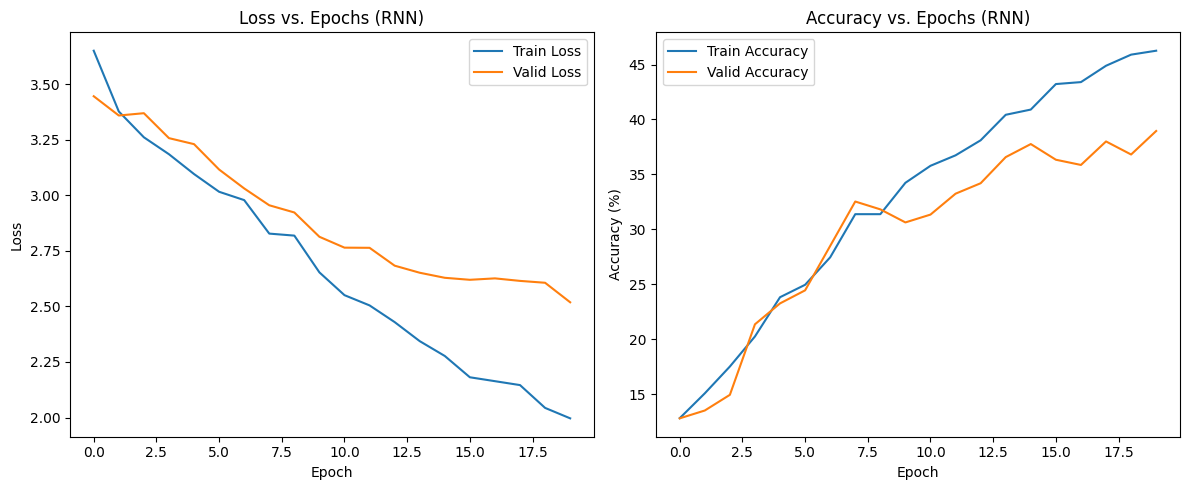


--- Post-Training Cleanup ---
Deleted rnn_model_global.
Deleted optimizer_global.
Deleted criterion_global.
Deleted train_loader_global.
Deleted test_loader_global.
Deleted glove_vectors_map_global.
Deleted unk_embedding_global.
Deleted GradScaler.
Deleted DataFrame 'df'.
Running garbage collection...
Emptying CUDA cache...
GPU Memory after final cleanup: Free 3724.00MB / Total 3897.75MB

Script execution completed.
If GPU memory is still not fully released by the OS/driver after script exits,
it might be held by the Python process itself (especially in interactive environments).
Restarting the Python kernel/session is often the most definitive way to release all CUDA context memory.
Ensure 'PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True' is set as an environment variable if fragmentation is suspected.


In [16]:
rnn_model_global = None
optimizer_global = None
criterion_global = None

if train_loader_global and test_loader_global and NUM_ACTUAL_CLS > 1:
    print(f"\nUsing device: {DEVICE}")
    if DEVICE == 'cuda':
        print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
        try:
            current_free_mem, total_mem = torch.cuda.mem_get_info()
            print(f"Initial GPU Memory: Free {current_free_mem/1024**2:.2f}MB / Total {total_mem/1024**2:.2f}MB")
        except Exception as e:
            print(f"Could not get initial GPU memory info: {e}")


    # Clean up sample batch if it exists from previous runs in an interactive session
    if 'x_batch_sample' in locals(): del x_batch_sample
    if 'y_batch_sample' in locals(): del y_batch_sample
    
    try:
        x_batch_sample, y_batch_sample = next(iter(train_loader_global))
        print(f"\nSample batch - X shape: {x_batch_sample.shape}, Y shape: {y_batch_sample.shape}")
        del x_batch_sample, y_batch_sample # Delete sample batch immediately to free memory
        if DEVICE == 'cuda': torch.cuda.empty_cache() # Clear cache after sample batch
    except Exception as e:
        print(f"Error getting a sample batch from train_loader: {e}")

    rnn_model_global = RNNModel(RNN_cell_type=RNN_TYPE_CLASS,
                         input_size=GLOVE_EMBEDDING_DIM,
                         hidden_size=RNN_HIDDEN_SIZE,
                         num_layers=RNN_NUM_LAYERS,
                         bidirectional=RNN_BIDIRECTIONAL,
                         num_cls=NUM_ACTUAL_CLS,
                         dropout_rate=RNN_DROPOUT_RATE
                         ).to(DEVICE)
    
    print(f"\nRNN Model ({RNN_TYPE_CLASS.__name__}) Initialized with {NUM_ACTUAL_CLS} output classes.")
    print(f"  Hidden Size: {RNN_HIDDEN_SIZE}, Bidirectional: {RNN_BIDIRECTIONAL}, Layers: {RNN_NUM_LAYERS}")

    criterion_global = nn.CrossEntropyLoss()
    optimizer_global = optim.Adam(rnn_model_global.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    best_valid_loss = float('inf')

    print(f"\n--- Starting Model Training (RNN with AMP, Grad Accum {ACCUMULATION_STEPS} steps, Batch Size {BATCH_SIZE}) ---")
    for epoch_idx in range(NUM_EPOCHS):
        rnn_model_global, train_loss, train_acc = train_one_epoch(rnn_model_global, train_loader_global, criterion_global, optimizer_global, epoch_idx, accumulation_steps=ACCUMULATION_STEPS)
        valid_loss, valid_acc = validate_model(rnn_model_global, test_loader_global, criterion_global)
        history['train_loss'].append(train_loss); history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc); history['valid_acc'].append(valid_acc)
        
        print(f"Epoch {epoch_idx+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation: Loss = {valid_loss:.4f}, Accuracy = {valid_acc:.2f}%")

        if valid_loss < best_valid_loss:
            torch.save(rnn_model_global.state_dict(), 'rnn_model_bug_assign_best.pt')
            best_valid_loss = valid_loss
            print('Model Saved as rnn_model_bug_assign_best.pt!')
        print("-" * 30)
        
        if DEVICE == 'cuda':
            torch.cuda.empty_cache() # Clear cache at the end of each epoch

    print("--- Training Finished (RNN with AMP) ---")

    if history['train_loss'] and plt is not None : # Check if training ran and plotting available
        try:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['valid_loss'], label='Valid Loss')
            plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs. Epochs (RNN)')
            plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='Train Accuracy'); plt.plot(history['valid_acc'], label='Valid Accuracy')
            plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Accuracy vs. Epochs (RNN)')
            plt.tight_layout(); plt.show()
        except Exception as e:
            print(f"Error during plotting: {e}. Ensure matplotlib is correctly installed and configured.")


else:
    print("Cannot start training: DataLoaders not initialized, insufficient classes, or GloVe vectors not loaded.")

# --- Post-Training Cleanup ---
print("\n--- Post-Training Cleanup ---")
if 'rnn_model_global' in locals() and rnn_model_global is not None:
    del rnn_model_global; print("Deleted rnn_model_global.")
if 'optimizer_global' in locals() and optimizer_global is not None:
    del optimizer_global; print("Deleted optimizer_global.")
if 'criterion_global' in locals() and criterion_global is not None:
    del criterion_global; print("Deleted criterion_global.")
if 'train_loader_global' in locals() and train_loader_global is not None:
    del train_loader_global; print("Deleted train_loader_global.")
if 'test_loader_global' in locals() and test_loader_global is not None:
    del test_loader_global; print("Deleted test_loader_global.")
if 'glove_vectors_map_global' in locals() and glove_vectors_map_global is not None:
    del glove_vectors_map_global; print("Deleted glove_vectors_map_global.")
if 'unk_embedding_global' in locals() and unk_embedding_global is not None :
    del unk_embedding_global; print("Deleted unk_embedding_global.")
if 'scaler' in locals() and scaler is not None:
    del scaler; print("Deleted GradScaler.")

# Delete dataframe and lists
if 'df' in locals(): del df; print("Deleted DataFrame 'df'.")
if 'texts' in locals(): del texts
if 'labels' in locals(): del labels
if 'train_texts' in locals(): del train_texts
if 'test_texts' in locals(): del test_texts
if 'train_labels' in locals(): del train_labels
if 'test_labels' in locals(): del test_labels
if 'train_data_list' in locals(): del train_data_list
if 'test_data_list' in locals(): del test_data_list
if 'assignee_encoder' in locals(): del assignee_encoder
if 'tokenizer' in locals(): del tokenizer


print("Running garbage collection...")
gc.collect()

if DEVICE == 'cuda':
    print("Emptying CUDA cache...")
    torch.cuda.empty_cache()
    try:
        current_free_mem, total_mem = torch.cuda.mem_get_info()
        print(f"GPU Memory after final cleanup: Free {current_free_mem/1024**2:.2f}MB / Total {total_mem/1024**2:.2f}MB")
    except Exception as e:
        print(f"Could not get GPU memory info after final cleanup: {e}")

print("\nScript execution completed.")
if DEVICE == 'cuda':
    print("If GPU memory is still not fully released by the OS/driver after script exits,")
    print("it might be held by the Python process itself (especially in interactive environments).")
    print("Restarting the Python kernel/session is often the most definitive way to release all CUDA context memory.")
    print("Ensure 'PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True' is set as an environment variable if fragmentation is suspected.")
